In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Reshape,Dropout,BatchNormalization,Flatten,Input,Conv2D,Conv2DTranspose,LeakyReLU,Dropout,Embedding,concatenate 
from IPython import display


In [2]:
#define parameters
LATENT_DIM = 64
BATCH_SIZE = 64
CLASSES = 10

In [3]:
#get the dataset
(x_train,y_train),_ = tf.keras.datasets.mnist.load_data()
#one hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train,CLASSES)
#normalize the images
x_train = x_train.astype(np.float32)/255.0

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
#convert to tf dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(3000)
dataset = dataset.batch(BATCH_SIZE,drop_remainder = True).prefetch(1)

In [11]:
#define the generator model
def generator():
  model = tf.keras.Sequential()
  model.add(Dense(7*7*74,input_shape=[LATENT_DIM+CLASSES]))
  model.add(LeakyReLU(0.1))
  
  
  model.add(Reshape([7,7,74]))
  model.add(Conv2DTranspose(138,(4,4),padding='same',strides=(2,2)))
  model.add(LeakyReLU(0.2))
  
  
  model.add(Conv2DTranspose(1,(4,4),padding='same',activation="sigmoid",strides=(2,2)))
  model.add(LeakyReLU(0.2))
  model.add((BatchNormalization()))
  
 
  
  return model

gen = generator()
gen.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 3626)              271950    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 3626)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 74)          0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 138)      163530    
 ranspose)                                                       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 138)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        2209      
 ranspose)                                            

In [10]:
#define discrminator model
def discriminator():
  model = tf.keras.Sequential()
  model.add(Conv2D(138,(4,4),strides=(2,2),padding="same",input_shape = [28,28,1+CLASSES]))
  model.add(LeakyReLU(0.2))
  
  model.add(Conv2D(74,(4,4),strides=(2,2),padding="valid"))
  model.add(LeakyReLU(0.2))
  
  model.add(Flatten())
  model.add(Dense(74))
  model.add(LeakyReLU(0.2))
  model.add((BatchNormalization()))
  model.add(Dense(1,activation="sigmoid"))
  return model

dis = discriminator()
dis.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 138)       24426     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 138)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 74)          163466    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 6, 6, 74)          0         
                                                                 
 flatten_2 (Flatten)         (None, 2664)              0         
                                                                 
 dense_6 (Dense)             (None, 74)                197210    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 74)               

In [12]:
#instantiate
#note that defining composite will not be useful here
#as we need to take as input the class label
dis = discriminator()
gen = generator()
dis.compile(loss="binary_crossentropy",optimizer="Adam")
dis.trainable = False
opt = tf.keras.optimizers.Adam()
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


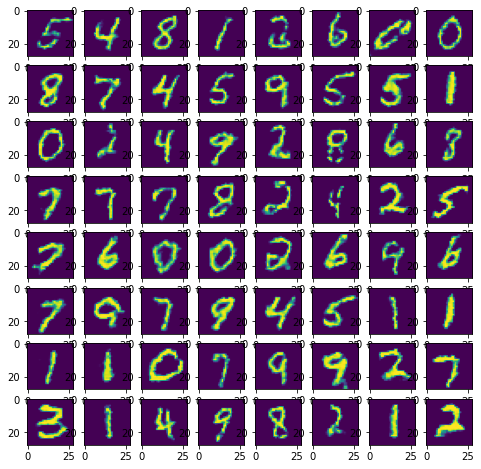

In [13]:
#train
#some print statements are commented out, were useful for debugging
def train(gen,dis,dataset,num_epochs):
  
  for epoch in range(num_epochs):
    print(epoch)
    for real_image_batch,label_batch in dataset:
      #print(label_batch.shape)
      labels = label_batch[:,:,None,None]
      #print(labels.shape)
      labels = tf.repeat(labels,repeats = [28*28])
      #print(labels.shape)
      labels = tf.reshape(labels,(-1,28,28,CLASSES))
      #print(labels.shape)
      latent = tf.random.normal([BATCH_SIZE,LATENT_DIM])
      #print(latent.shape)
      latent = tf.concat([latent,label_batch],axis=1)
      #print(latent.shape)
      gen_image_batch = gen(latent)
      #print(gen_image_batch.shape)
      real_image_and_labels = tf.concat([real_image_batch[:,:,:,None],labels],-1)
      fake_image_and_labels = tf.concat([gen_image_batch,labels],-1)
      #create input for discrim training
      x_concat = tf.concat([real_image_and_labels,fake_image_and_labels],axis=0)
      y_concat = tf.concat([tf.convert_to_tensor(np.ones(BATCH_SIZE)),tf.convert_to_tensor(np.zeros(BATCH_SIZE))],axis=0)
      dis.trainable = True
      #train discrim
      dis.train_on_batch(x_concat,y_concat)
      #fix discriminator weights
      dis.trainable = False
      latent = tf.random.normal([BATCH_SIZE,LATENT_DIM])
      latent = tf.concat([latent,label_batch],axis=1)
      y = tf.convert_to_tensor(np.ones(BATCH_SIZE))
      
      with tf.GradientTape() as tape:
        gen_image_batch = gen(latent)
        fake_image_and_labels = tf.concat([gen_image_batch,labels],-1)
        pred = dis(fake_image_and_labels)
        gen_loss = loss(y,pred)
      grad = tape.gradient(gen_loss,gen.trainable_weights)
      #train the generator
      opt.apply_gradients(zip(grad, gen.trainable_variables))
  plot(gen_image_batch)

train(gen,dis,dataset,20)

(64, 10)
(64, 64)
(64, 74)


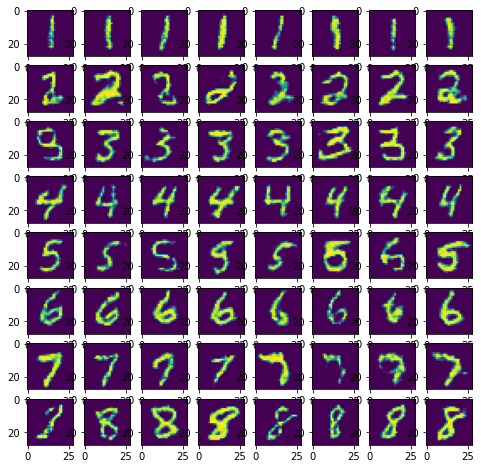

In [14]:
def plot(images):
  #enter a square num of images
  num = np.sqrt(len(images))
  plt.figure(figsize=(num,num))
  for index, image in enumerate(images):
    plt.subplot(num,num,index+1)
    plt.imshow(image[:,:,0])

#create input to test and plot
arr = [[1]*8 + [2]*8 + [3]*8 + [4]*8 + [5]*8 + [6]*8 + [7]*8+ [8]*8]
arr = arr[0]
arr = tf.keras.utils.to_categorical(tf.convert_to_tensor(arr),CLASSES)
print(arr.shape)
latent = tf.random.normal([BATCH_SIZE,LATENT_DIM])
print(latent.shape)
latent = tf.concat([latent,arr],axis=1)
print(latent.shape)
gen_image_batch = gen(latent)
plot(gen_image_batch)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
gen.save("/content/drive/MyDrive/condGAN_MNIST/gen")
dis.save("/content/drive/MyDrive/condGAN_MNIST/dis")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/condGAN_MNIST/gen/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/condGAN_MNIST/dis/assets
